In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import json
from tqdm.auto import tqdm
import os
import numpy as np
import random
import seaborn as sns
from matplotlib_venn import venn3
import yaml
from collections import Counter
import os
%matplotlib inline

In [3]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

mappings = load_config("../../datasets/final/hierarchical_label_set.yaml")
lvl1_to_lvl2 = mappings["lvl1_to_lvl2"]
lvl1_to_lvl3 = mappings["lvl1_to_lvl3"]

In [4]:
#Function to map a list of locations from one database to the common classes
def map_list(locations, map, sep=";"):
    if locations == '':
        return ''
    locations = locations.split(sep)
    locations = [map[loc] for loc in locations if map[loc]!='']
    locations = list(np.unique(locations))
    return ";".join(locations)

In [5]:
def write_fasta(fasta_name, keys, sequences):
    with open(fasta_name, "w") as f:
        for i, key in enumerate(keys):
            seq = sequences[i]
            f.write(f">{key}\n")
            f.write(f"{seq}\n")

### Adding canonical sequences

First we ned to add canonical sequences to the HPA and OpenCell datasets. To do we need to run the utils/get_canonical.py inside the bash script which is run by the following cell

In [7]:
! ../../scripts/bash/get_canonical_seqs.sh

/bin/bash: ../../scripts/bash/get_canonical_seqs.sh: Permission denied


### Filtering  HPA Data

Now, we collect HPA annotations and filter by the following criteria.
<ol>
    <li>From version 24</li>
    <li>Status 35 (INSERT WHAT "STATUS" MEANS)</li>
    <li>Reliability of the anitbody is Supported, Approved or Enhanced </li>
    <li>Has location annotations</li>
    <li>From "Normal" cells (ie not Cilia version)</li>
    <li>Has only 1 ensembl id</li>
</ol>

Combine the localization annotations across all cell types for each gene

Map HPA localization annotations to our sets of classes

Filter for sequences that are at least 40 residues log and start with "M" and then save the new dataframe

In [9]:
hpa_path = "../datasets/raw/HPA_2024_IF-image.csv"

if not os.path.exists("../datasets/intermediate/building/hpa_raw.csv"):
    hpa = pd.read_csv(hpa_path)
    hpa = hpa[(hpa['latest_version'] == 24)]
    hpa = hpa[hpa['status'] == 35]
    hpa = hpa[hpa['Gene reliability (in release)'].isin(['Supported', 'Approved', 'Enhanced'])] #Should I get rid of "Enhanced" this reduces the number of proteins by 1000
    hpa = hpa[hpa['locations'].notna()]
    hpa = hpa[hpa["Channel scheme"] == "Normal"] #Ignore Cilia
    hpa = hpa[~hpa["ensembl_ids"].str.contains(",")]
    hpa_locs = hpa.groupby("ensembl_ids").locations.apply(",".join).reset_index()
    def combine_locs(locs):
        return ",".join(list(set(locs.split(","))))
    hpa_locs.locations = hpa_locs.locations.apply(combine_locs) #delete duplicate localizations after merging cell-types
    hpa_locs["locations"] = hpa_locs.locations.str.replace(",", ";")

    hpa_to_lvl1 = mappings["hpa_to_lvl1"]
    hpa_locs.loc[:,"level1"] = hpa_locs.locations.apply(lambda x: map_list(x, hpa_to_lvl1))
    hpa_locs.loc[:, "level2"] = hpa_locs.level1.apply(lambda x: map_list(x, lvl1_to_lvl2))
    hpa_locs.loc[:, "level3"] = hpa_locs.level1.apply(lambda x: map_list(x, lvl1_to_lvl3))

    # Only take proteins that were successfully mapped
    hpa_locs = hpa_locs[
        (hpa_locs.level1 != "") & 
        (hpa_locs.level2 != "") & 
        (hpa_locs.level3 != "")]

    hpa_locs = hpa_locs[hpa_locs.Sequence.notnull()]
    hpa_locs = hpa_locs[hpa_locs.Sequence.str.len()>=40]
    hpa_locs = hpa_locs[hpa_locs.Sequence.str.startswith("M")]

    #Save
    hpa_locs.to_csv("../datasets/intermediate/building/hpa_raw.csv", index=False) 

### Filtering OpenCell Data

Map OpenCell localization annotations to our sets of classes

Filter for sequences that are at least 40 residues log and start with "M" and then save the new dataframe

In [15]:
opencell_path = f"../datasets/raw/opencell-localization-annotations.csv"

if not os.path.exists("../datasets/intermediate/building/building/opencell_raw.csv"):
    opencell_locs = pd.read_csv(opencell_path)
    opencell_locs = opencell_locs.rename({"ensg_id": "ensembl_ids"}, axis=1)
    opencell_locs = opencell_locs[~opencell_locs.annotations_grade_3.isnull()].reset_index(drop=True)
    opencell_to_lvl1 = mappings["opencell_to_lvl1"]

    opencell_locs.loc[:,"level1"] = opencell_locs.annotations_grade_3.apply(lambda x: map_list(x, opencell_to_lvl1))
    opencell_locs.loc[:,"level2"] = opencell_locs.level1.apply(lambda x: map_list(x, lvl1_to_lvl2))
    opencell_locs.loc[:,"level3"] = opencell_locs.level1.apply(lambda x: map_list(x, lvl1_to_lvl3))

    opencell_locs = opencell_locs[
        (opencell_locs.level1 != "") & 
        (opencell_locs.level2 != "") & 
        (opencell_locs.level3 != "")]

    opencell_locs = opencell_locs[opencell_locs.Sequence.notnull()]
    opencell_locs = opencell_locs[opencell_locs.Sequence.str.len()>=40]
    opencell_locs = opencell_locs[opencell_locs.Sequence.str.startswith("M")]

    opencell_locs.to_csv("../datasets/intermediate/building/opencell_raw.csv", index=False) 

### Gathering + Filtering UniProt(SwissProt Reviewed) Data

UniProt data was downloaded from https://www.uniprot.org/ after filtering for "Reviewed" entries and the taxonomy id for eukaryotes, 2759

Two formats of UniProt data were downloaded: a json for easily parsing SubCellular location information and a smaller tsv containing information relevant for filtering steps

We filter UniProt proteins based on the following criteria: 
<ol>
  <li>Sequence is at least 40 residues</li>
  <li>Starts with Methionine</li>
  <li>Not fragments</li>
  <li>Encoded in the nucleus</li>
  <li>Has at least one location annotation from experimental evidence</li>
</ol>

In [5]:
def get_ensembl_id(uniprot_entry):
    ids = []
    gene_names = []
    if 'genes' in uniprot_entry.keys():
        genes = uniprot_entry['genes']
        for g in genes:
            if 'geneName' in g.keys():
                gene_name = g['geneName']['value']
                gene_names.append(gene_name)
                try:
                    ensembl_id = genome.gene_ids_of_gene_name(gene_name)
                    for x in ensembl_id:
                        ids.append(x)
                except:
                    pass #this one doesn't have an ensembl id
    ids = ",".join(list(np.unique(ids)))
    gene_names = ",".join(list(np.unique(gene_names)))
    return ids, gene_names

In [6]:
def get_uniprot_locations(uniprot_entry):
    final_locs = []
    final_evidences = []
    final_sources = []
    if "comments" in uniprot_entry.keys():
        cs = uniprot_entry["comments"]
        for c in cs:
            if c['commentType'] == 'SUBCELLULAR LOCATION':
                if "subcellularLocations" in c.keys():
                    uni_locs = c["subcellularLocations"]
                    locs = []
                    evidences = []
                    sources = []
                    for uni_loc in uni_locs:
                        loc = uni_loc["location"]["value"]
                        loc = loc.split(",")
                        loc = [l.strip() for l in loc]
                        locs += loc
                        if "evidences" in uni_loc["location"].keys():
                            evidence = []
                            source = []
                            uniprot_evs = uni_loc["location"]["evidences"]
                            for uniprot_ev in uniprot_evs:
                                ev = uniprot_ev["evidenceCode"]
                                evidence.append(ev)
                                if "source" in uniprot_ev.keys() and "id" in uniprot_ev.keys():
                                    s = f"{uniprot_ev["source"]}_{uniprot_ev["id"]}"
                                else:
                                    s = "None"
                                source.append(s)
                            assert len(evidence) == len(source)
                            evidence = "-".join(evidence)
                            source = "-".join(source)
                        else: 
                            evidence = ""
                            source = ""
                        for i in range(len(loc)):
                            evidences.append(evidence)
                            sources.append(source)
                        assert len(locs) == len(evidences) and len(evidences) == len(sources)
                    final_locs += locs
                    final_evidences += evidences
                    final_sources += sources
                    assert len(final_locs) == len(final_evidences) and len(final_evidences) == len(final_sources)
        if final_locs or final_evidences: #if either nonempty
            assert len(final_locs) == len(final_evidences)
            final_locs = ";".join(final_locs)
            final_evidences = ";".join(final_evidences)
            final_sources = ";".join(final_sources)
            return final_locs, final_evidences, final_sources
    return "", "", ""

In [7]:
def eco269_locs(locations, evidence_codes):
    locations = locations.split(";")
    evidence_codes = evidence_codes.split(";")
    assert len(locations) == len(evidence_codes)

    keep_locs = set()
    for i, loc in enumerate(locations):
        eco = evidence_codes[i]
        if "ECO:0000269" in evidence_codes[i]:
            keep_locs.add(loc)
    
    return ";".join(list(keep_locs))

In [8]:
if not os.path.exists("../datasets/intermediate/building/uniprot_raw.csv"):

    eukaryote_uniprot_tsv_path = "../datasets/raw/uniprotkb_taxonomy_id_2759_AND_reviewed_2024_12_10.tsv"
    eukaryote_uniprot_json_path = "../datasets/raw/uniprotkb_taxonomy_id_2759_AND_reviewed_2024_12_10.json"

    with open(eukaryote_uniprot_json_path) as f:
        temp = json.load(f)['results']

    uniprot = []
    for i in tqdm(temp):
        if i['entryType'] == 'UniProtKB reviewed (Swiss-Prot)':
            uniprot.append(i)
    del(temp)

    #Build a DataFrame with relevant information, subcellular location and other metadata from the tsv
    uniprot_ids = []
    ensembl_ids = []
    gene_names = []
    locations = []
    evidence_codes = []
    sources = []
    for i in range(len(uniprot)):
        uniprot_entry = uniprot[i]
        uniprot_id = uniprot[i]["primaryAccession"]
        ensembl_id, gene_name = get_ensembl_id(uniprot_entry)
        loc, evidence, source = get_uniprot_locations(uniprot_entry)
        uniprot_ids.append(uniprot_id)
        ensembl_ids.append(ensembl_id)
        gene_names.append(gene_name)
        locations.append(loc)
        evidence_codes.append(evidence)
        sources.append(source)
    uniprot_locs = pd.DataFrame()
    uniprot_locs["uniprot_id"] = uniprot_ids
    uniprot_locs["ensembl_ids"] = ensembl_ids
    uniprot_locs["gene_names"] = gene_names
    uniprot_locs["locations"] = locations
    uniprot_locs["evidence_codes"] = evidence_codes
    uniprot_locs["sources"] = sources
    uniprot_locs = uniprot_locs.replace(r'', np.NaN)

    uniprot_table = pd.read_csv(eukaryote_uniprot_tsv_path, sep="\t")
    uniprot_table = uniprot_table.rename({"Entry": "uniprot_id"}, axis=1)
    assert (uniprot_table.uniprot_id.unique() == uniprot_locs.uniprot_id.unique()).all()
    uniprot_locs = uniprot_locs.merge(uniprot_table, on="uniprot_id")


    #Filter dataframe
    num_before = len(uniprot_locs)
    uniprot_locs = uniprot_locs[uniprot_locs.Length >= 40]
    uniprot_locs = uniprot_locs[uniprot_locs.Sequence.str[0]=="M"]
    uniprot_locs = uniprot_locs[uniprot_locs.Fragment != "fragment"] #Not a fragment
    uniprot_locs = uniprot_locs[uniprot_locs["Gene encoded by"].isnull()] #Encoded in the nucleus
    uniprot_locs = uniprot_locs[uniprot_locs.evidence_codes.notnull()]
    uniprot_locs = uniprot_locs[uniprot_locs.evidence_codes.str.contains("ECO:0000269")] #has at least one location annotation with experimental evidence
    uniprot_locs = uniprot_locs.reset_index(drop=True)
    num_after = len(uniprot_locs)

    print(f"{num_before} proteins before filtering")
    print(f"{num_after} proteins after filtering")

    #Check that none of the localization annotations in UniProt were taken from HPA (PMID: 28940711) or OpenCell publications (PMID: 35271311)
    assert len(uniprot_locs[uniprot_locs.sources.str.contains("28940711")]) == 0
    assert len(uniprot_locs[uniprot_locs.sources.str.contains("35271311")]) == 0

    #Gather the experimentally validated localization annotations (ECO:0000269) in our dataset and add new column in our DataFrame to record them.
    locations = uniprot_locs.locations.to_list()
    evidence_codes = uniprot_locs.evidence_codes.to_list()
    uniprot_locs["exp_locations"] = [eco269_locs(z[0], z[1]) for z in zip(locations, evidence_codes)]


    #Map to our label set
    uniprot_to_lvl1 = mappings["uniprot_to_lvl1"]
    uniprot_locs.loc[:,"level1"] = uniprot_locs.exp_locations.apply(lambda x: map_list(x, uniprot_to_lvl1))
    uniprot_locs.loc[:, "level2"] = uniprot_locs.level1.apply(lambda x: map_list(x, lvl1_to_lvl2))
    uniprot_locs.loc[:, "level3"] = uniprot_locs.level1.apply(lambda x: map_list(x, lvl1_to_lvl3))

    uniprot_locs = uniprot_locs[
        (uniprot_locs.level1 != "") & 
        (uniprot_locs.level2 != "") & 
        (uniprot_locs.level3 != "")]
    uniprot_locs.to_csv("../datasets/intermediate/building/uniprot_raw.csv", index=False)

  0%|          | 0/198746 [00:00<?, ?it/s]

/tmp/ipykernel_53151/1520775689.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uniprot_locs = uniprot_locs.replace(r'', np.NaN)


198746 proteins before filtering
35072 proteins after filtering


In [15]:
opencell2 = pd.read_csv("../datasets/intermediate/building/uniprot_raw.csv")
opencell1 = pd.read_csv("../Building-Datasets/data/intermediate/building/uniprot_raw.csv")

### Generating HOU benchmark test set: Taking the intersection of HPA, OpenCell and UniProt

In [17]:
hpa_locs = pd.read_csv("../datasets/intermediate/building/hpa_raw.csv")
opencell_locs = pd.read_csv("../datasets/intermediate/building/opencell_raw.csv")
uniprot_locs = pd.read_csv("../datasets/intermediate/building/uniprot_raw.csv")

In [18]:
# There is one uniprot_id repeated in the hpa set
# This must be a mistake 
# Bc we index by uniprot id, we only keep 1
temp = hpa_locs.uniprot_id.value_counts() 
repeated_ids = temp[temp > 1].index.to_list()
display(hpa_locs[hpa_locs.uniprot_id.isin(repeated_ids)])

# We drop one of the repeats
hpa_locs = hpa_locs[hpa_locs.ensembl_ids != "ENSG00000163041"]


#Then make sure there are no repeat uniprot ids in any of the datasets
temp = hpa_locs.uniprot_id.value_counts() 
assert (temp == 1).all()

temp = opencell_locs.uniprot_id.value_counts() 
assert (temp == 1).all()

temp = uniprot_locs.uniprot_id.value_counts() 
assert (temp == 1).all()

,Unnamed: 0,ensembl_ids,locations,level1,level2,level3,uniprot_id,Sequence
4494,4494,ENSG00000132475,Nucleoplasm;Micronucleus,nuclear-bodies;nucleoplasm,nucleus,nucleus,P84243,MARTKQTARKSTGGKAPRKQLATKAARKSAPSTGGVKKPHRYRPGT...
7313,7313,ENSG00000163041,Nucleoplasm,nucleoplasm,nucleus,nucleus,P84243,MARTKQTARKSTGGKAPRKQLATKAARKSAPSTGGVKKPHRYRPGT...


In [19]:
hpa_locs = hpa_locs[["uniprot_id", "ensembl_ids", "Sequence", "level1", "level2", "level3"]]
hpa_locs.rename({
    "level1": "hpa_level1", 
    "level2": "hpa_level2", 
    "level3": "hpa_level3", 
    "Sequence": "hpa_Sequence",
    "ensembl_ids": "hpa_ensembl_id"
    }, axis=1, inplace=True)
hpa_locs["hpa"] = True

opencell_locs = opencell_locs[["uniprot_id", "ensembl_ids", "Sequence", "level1", "level2", "level3"]]
opencell_locs.rename({
    "level1": "opencell_level1", 
    "level2": "opencell_level2", 
    "level3": "opencell_level3", 
    "Sequence": "opencell_Sequence",
    "ensembl_ids": "opencell_ensembl_id"
    }, axis=1, inplace=True)
opencell_locs["opencell"] = True

uniprot_locs["human"] = uniprot_locs.Organism == "Homo sapiens (Human)"
uniprot_locs = uniprot_locs[["uniprot_id", "ensembl_ids", "Sequence", "level1", "level2", "level3", "human"]]
uniprot_locs.rename({
    "level1": "uni_level1", 
    "level2": "uni_level2", 
    "level3": "uni_level3", 
    "Sequence": "uni_Sequence",
    "ensembl_ids": "uni_ensembl_id"
    }, axis=1, inplace=True)
uniprot_locs["uniprot"] = True

merged = hpa_locs.merge(opencell_locs, on="uniprot_id", how="outer")
merged = merged.merge(uniprot_locs, on="uniprot_id", how="outer")
merged[["hpa", "opencell", "uniprot"]] = merged[["hpa", "opencell", "uniprot"]].fillna(False)
merged["human"] = merged["human"].fillna(True)

/tmp/ipykernel_53151/3857509848.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged[["hpa", "opencell", "uniprot"]] = merged[["hpa", "opencell", "uniprot"]].fillna(False)
/tmp/ipykernel_53151/3857509848.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged["human"] = merged["human"].fillna(True)


In [20]:
#Make 1 column to combine ensemble ids
#Note: Uniprot sometimes has multiple ensmble ids for 1 uniprot id
#Note: Not all human proteins from uniprot have ensembl id --> weird
merged["ensembl_id"] = merged.hpa_ensembl_id.where(
    merged.hpa_ensembl_id.notnull(),  merged.uni_ensembl_id)

merged.loc[:, "ensembl_id"] = merged.ensembl_id.where(
    merged.ensembl_id.notnull(), merged.opencell_ensembl_id)

In [21]:
#Check that there is only one uniprot id per protein
assert merged.uniprot_id.str.contains(",").any() == False

#Check that no uniprot id is repeated
assert (merged.uniprot_id.value_counts() == 1).all()

In [22]:
print("There is one sequence that is not the same between hpa and uniprot")
print("Probably because gget is pulling from old version of uniprot")
temp = merged[
        (merged.hpa_Sequence.notna()) &
        (merged.uni_Sequence.notna()) &
        (merged.hpa_Sequence != merged.uni_Sequence)
        ]
display(temp)
hpa_seq = temp["hpa_Sequence"].item()
uni_seq = temp["uni_Sequence"].item()
s = [hpa_seq[i] == uni_seq[i] for i in range(len(hpa_seq))]
diff_residues = (~np.array(s)).sum()
print(f"Sequences differ by {diff_residues} residues")
print("We just take the UniProt sequence")
idx = temp.index.to_list()
merged.loc[idx, "hpa_Sequence"] = pd.NA

There is one sequence that is not the same between hpa and uniprot
Probably because gget is pulling from old version of uniprot


,uniprot_id,hpa_ensembl_id,hpa_Sequence,hpa_level1,hpa_level2,hpa_level3,hpa,opencell_ensembl_id,opencell_Sequence,opencell_level1,...,opencell_level3,opencell,uni_ensembl_id,uni_Sequence,uni_level1,uni_level2,uni_level3,human,uniprot,ensembl_id
19515,Q5VST9,ENSG00000154358,MDQPQFSGAPRFLTRPKAFVVSVGKDATLSCQIVGNPTPQVSWEKD...,cytosol;nuclear-bodies;plasma-membrane,cytosol;nucleus;plasma-membrane,cytosol;nucleus;plasma-membrane,True,NaN,NaN,NaN,...,NaN,False,NaN,MDQPQFSGAPRFLTRPKAFVVSVGKDATLSCQIVGNPTPQVSWEKD...,actin-filaments;cytoskeleton;cytosol,cytoskeleton;cytosol,cytoskeleton;cytosol,True,True,ENSG00000154358


Sequences differ by 2 residues
We just take the UniProt sequence


In [23]:
#Check that sequences agree between databases
assert len(
        merged[
            (merged.hpa_Sequence.notna()) &
            (merged.uni_Sequence.notna()) &
            (merged.hpa_Sequence != merged.uni_Sequence)
            ]
        ) == 0

assert len(
        merged[
            (merged.opencell_Sequence.notna()) &
            (merged.uni_Sequence.notna()) &
            (merged.opencell_Sequence != merged.uni_Sequence)
            ]
        ) == 0 

assert len(
        merged[
            (merged.hpa_Sequence.notna()) &
            (merged.opencell_Sequence.notna()) &
            (merged.opencell_Sequence != merged.hpa_Sequence)
            ]
        ) == 0


merged["Sequence"] = merged.uni_Sequence.where(merged.uni_Sequence.notnull(), merged.hpa_Sequence)
merged["Sequence"] = merged.Sequence.where(merged.Sequence.notnull(), merged.opencell_Sequence)
merged = merged.drop(["hpa_Sequence", "opencell_Sequence", "uni_Sequence"], axis=1)

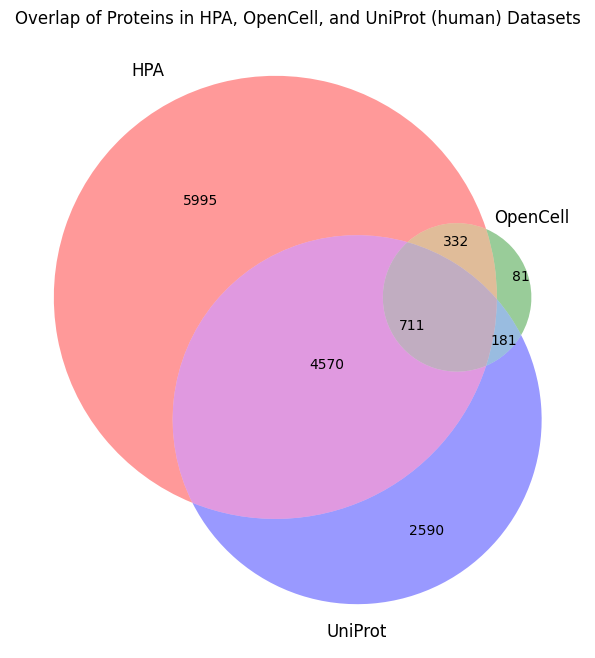

In [24]:
#Visualize Overlap
hpa_keys = set(merged[merged.hpa].uniprot_id.to_list())
opencell_keys = set(merged[merged.opencell].uniprot_id.to_list())
uniprot_keys = set(merged[(merged.uniprot) & (merged.human)].uniprot_id.to_list())

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn3([hpa_keys, opencell_keys, uniprot_keys], ('HPA', 'OpenCell', 'UniProt'))

# Display the plot
plt.title("Overlap of Proteins in HPA, OpenCell, and UniProt (human) Datasets")
plt.show()

In [25]:
def list_to_set(locs_entry):
    if locs_entry == "": return set()
    else: return set(locs_entry.split(";"))

def locs_in_two(l1, l2, l3):
    #Keep localization annotation if in at least 2 datasets
    s1 = list_to_set(l1)
    s2 = list_to_set(l2)
    s3 = list_to_set(l3)
    
    add = []    
    #Often UniProt/OpenCell do not specify the part of cytoskeleton, but HPA does
    # If, for example, HPA says specifically "microtubules" and UniProt says "cytoskeleton" 
    # we take more specific compartment.
    if "cytoskeleton" in s2.union(s3):
        if "actin-filaments" in s1:
            add.append("actin-filaments")
        if "intermediate-filaments" in s1:
            add.append("intermediate-filaments")
        if "centrosome" in s1:
            add.append("centrosome")
        if "microtubules" in s1:
            add.append("microtubules")
    
    #Often HPA/OpenCell do not specify the vesicle, but UniProt does
    # If, for example, UniProt says specifically "microtubules" and HPA says "cytoskeleton" 
    # we take more specific compartment.
    if "vesicles" in s1.union(s2):
        if "endosomes" in s3:
            add.append("endosomes")
        if "lysosomes" in s3:
            add.append("lysosomes")
        if "peroxisome" in s3:
            add.append("peroxisomes")
        if "lipid-droplets" in s3:
            add.append("lipid-droplets")


    i1 = s1.intersection(s2)
    i2 = s2.intersection(s2)
    i3 = s1.intersection(s3)

    out = list(set.union(*[i1, i2, i3]).union(set(add)))
    
    return ";".join(out)

In [26]:
#Combine overlapping annotations from different datasets
merged.loc[:, ["hpa_level1", "opencell_level1", "uni_level1"]] = merged[["hpa_level1", "opencell_level1", "uni_level1"]].fillna("")
merged.loc[:, "hou_level1"] = merged.apply(lambda x: locs_in_two(x["hpa_level1"], 
                                                                x["opencell_level1"], 
                                                                x["uni_level1"]), axis=1)

merged.loc[:, ["hpa_level2", "opencell_level2", "uni_level2"]] = merged[["hpa_level2", "opencell_level2", "uni_level2"]].fillna("")
merged.loc[:, "hou_level2"] = merged.apply(lambda x: locs_in_two(x["hpa_level2"], 
                                                                x["opencell_level2"], 
                                                                x["uni_level2"]), axis=1)

merged.loc[:, ["hpa_level3", "opencell_level3", "uni_level3"]] = merged[["hpa_level3", "opencell_level3", "uni_level3"]].fillna("")
merged.loc[:, "hou_level3"] = merged.apply(lambda x: locs_in_two(x["hpa_level3"], 
                                                                x["opencell_level3"], 
                                                                x["uni_level3"]), axis=1)

In [27]:
# Make column for all proteins that have potential to be in HOU
merged["HOU"] = False
merged.loc[(merged.hou_level1 != ""), "HOU"] = True

In [28]:
#Sanity check that all proteins in HOU are human
assert merged[merged.HOU].human.all()

In [29]:
#Save csvs/fastas for downstream tasks

merged.to_csv("../datasets/intermediate/building/mapped_locations_all_datasetsdata.csv", index=False)

hou_df = merged[merged.HOU]
keys = hou_df.uniprot_id.to_list()
sequences = hou_df.Sequence.to_list()
fasta_name = "../datasets/fastas/hou.fasta"
write_fasta(fasta_name, keys, sequences)

hpa_df = merged[merged.hpa]
keys = hpa_df.uniprot_id.to_list()
sequences = hpa_df.Sequence.to_list()
fasta_name = "../datasets/fastas/hpa.fasta"
write_fasta(fasta_name, keys, sequences)

uni_df = merged[merged.uniprot]
keys = uni_df.uniprot_id.to_list()
sequences = uni_df.Sequence.to_list()
fasta_name = "../datasets/fastas/uniprot.fasta"
write_fasta(fasta_name, keys, sequences)